In [1]:
import pandas as pd
from pathlib import Path
import json
import seaborn as sns
import requests
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
LOAD_LOAD_DIR = Path(
    Path.cwd().parent, "data.nosync", "combined_data", "combined_load.parquet"
)

In [3]:
load_df = pd.read_parquet(LOAD_LOAD_DIR)

In [4]:
load_df.head()

,Time Stamp,Time Zone,Name,PTID,Load
0,2016-06-22,EDT,CAPITL,61757.0,1252.099976
1,2016-06-22,EDT,CENTRL,61754.0,1594.699951
2,2016-06-22,EDT,DUNWOD,61760.0,717.099976
3,2016-06-22,EDT,GENESE,61753.0,1028.699951
4,2016-06-22,EDT,HUD VL,61758.0,1065.500000


# Data Stats

In [5]:
load_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17999300 entries, 0 to 17999299
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Time Stamp  datetime64[ns]
 1   Time Zone   category      
 2   Name        category      
 3   PTID        float32       
 4   Load        float32       
dtypes: category(2), datetime64[ns](1), float32(2)
memory usage: 309.0 MB


In [6]:
load_df.isna().sum()

Time Stamp      0
Time Zone       0
Name            0
PTID            0
Load          404
dtype: int64

In [7]:
load_df.describe()

,Time Stamp,PTID,Load
count,17999300,1.799930e+07,1.799890e+07
mean,2015-09-28 11:15:32.816672768,6.175814e+04,1.647269e+03
min,2008-01-01 00:00:00,6.175200e+04,-1.166500e+03
25%,2011-11-16 12:43:45,6.175400e+04,7.381000e+02
50%,2015-09-18 22:17:30,6.175700e+04,1.186100e+03
75%,2019-08-18 18:51:15,6.176000e+04,1.837100e+03
max,2023-06-16 11:15:00,6.176200e+04,1.150620e+04
std,NaN,3.162278e+00,1.561328e+03


In [8]:
load_df.nunique()

Time Stamp    1636123
Time Zone           2
Name               11
PTID               11
Load          3294320
dtype: int64

In [9]:
load_df["Name"].unique()

['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', ..., 'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']
Length: 11
Categories (11, object): ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', ..., 'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']

Going to have to map the weather stations to the correct area at some point. 

# Transforming date

Extracting date parts from the datetime column

In [10]:
load_df["Year"] = load_df["Time Stamp"].dt.year
load_df["Month"] = load_df["Time Stamp"].dt.month
load_df["Day"] = load_df["Time Stamp"].dt.day
load_df["Hour"] = load_df["Time Stamp"].dt.hour
load_df["Minute"] = load_df["Time Stamp"].dt.minute

In [11]:
load_df.head()

,Time Stamp,Time Zone,Name,PTID,Load,Year,Month,Day,Hour,Minute
0,2016-06-22,EDT,CAPITL,61757.0,1252.099976,2016,6,22,0,0
1,2016-06-22,EDT,CENTRL,61754.0,1594.699951,2016,6,22,0,0
2,2016-06-22,EDT,DUNWOD,61760.0,717.099976,2016,6,22,0,0
3,2016-06-22,EDT,GENESE,61753.0,1028.699951,2016,6,22,0,0
4,2016-06-22,EDT,HUD VL,61758.0,1065.500000,2016,6,22,0,0


# Visualization

The two images below show how the New York State is split up into regions corresponding to the "Name" in the dataframe

![alternative text](/Users/jamesmoro/Documents/Python/Energy-Forecasting/data_information/Load_map1.png)

![alternative text](/Users/jamesmoro/Documents/Python/Energy-Forecasting/data_information/Load_map2.png)

Average yearly load by name

In [12]:
load_by_month = load_df.groupby(["Name", "Month"], as_index=False).mean(
    numeric_only=True
)[["Name", "Month", "Load"]]
load_by_month["Name"] = load_by_month["Name"].cat.remove_unused_categories()

Text(0.5, 1.0, 'Load by Month and Site')

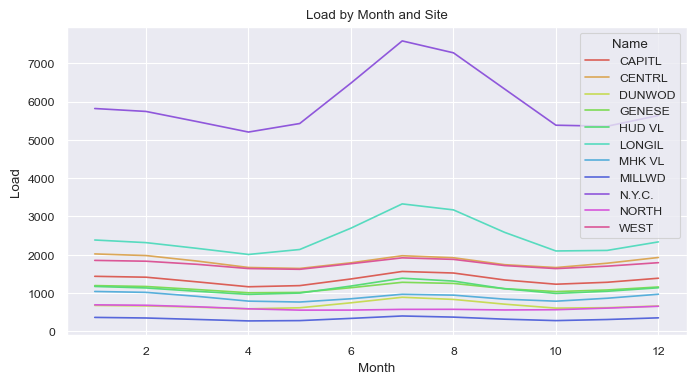

In [13]:
sns.set_theme("paper")
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(
    data=load_by_month,
    x="Month",
    y="Load",
    hue="Name",
    ax=ax,
    palette=sns.color_palette("hls", 11),
)

ax.set_title("Load by Month and Site")

Massive load spike for NYC during the summer, as to be expected when every turns on their AC. There are also a large bump in the summer in Long Island, assumed because everyone goes out to their summer properties. 

Load by time of day

In [14]:
load_by_hour = load_df.groupby(["Name", "Hour"], as_index=False).mean(
    numeric_only=True
)[["Name", "Hour", "Load"]]
load_by_hour["Name"] = load_by_hour["Name"].cat.remove_unused_categories()

Text(0.5, 1.0, 'Load by Hour and Site')

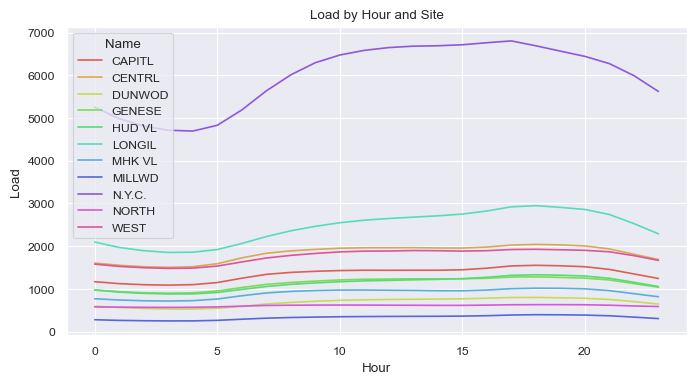

In [15]:
sns.set_theme("paper")
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(
    data=load_by_hour,
    x="Hour",
    y="Load",
    hue="Name",
    ax=ax,
    palette=sns.color_palette("hls", 11),
)

ax.set_title("Load by Hour and Site")

As expected, power demand decreases over night and in the early hours. Can also see here that NYC is well above other areas in electricity demand. 

In [16]:
load_df.head()

,Time Stamp,Time Zone,Name,PTID,Load,Year,Month,Day,Hour,Minute
0,2016-06-22,EDT,CAPITL,61757.0,1252.099976,2016,6,22,0,0
1,2016-06-22,EDT,CENTRL,61754.0,1594.699951,2016,6,22,0,0
2,2016-06-22,EDT,DUNWOD,61760.0,717.099976,2016,6,22,0,0
3,2016-06-22,EDT,GENESE,61753.0,1028.699951,2016,6,22,0,0
4,2016-06-22,EDT,HUD VL,61758.0,1065.500000,2016,6,22,0,0


Load distribution by name

<Axes: xlabel='Name', ylabel='Load'>

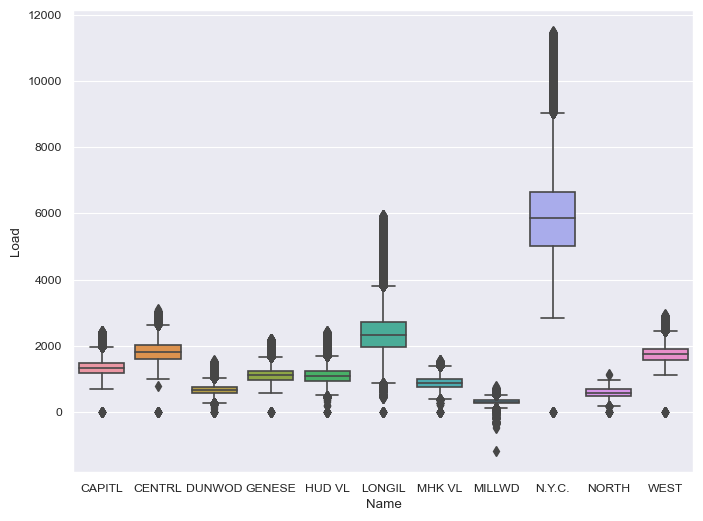

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=load_df, x="Name", y="Load", ax=ax)

# Correlations

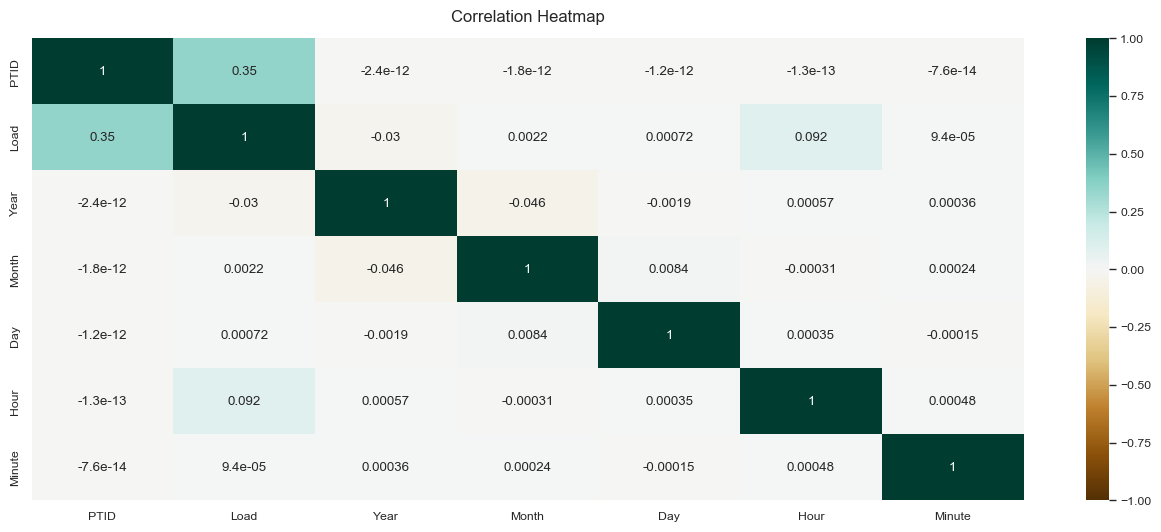

In [18]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(
    load_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="BrBG"
)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title("Correlation Heatmap", fontdict={"fontsize": 12}, pad=12);

In [19]:
LOAD_SAVE_DIR = Path(
    Path.cwd().parent, "data.nosync", "transformed_data", "load_transformed.parquet"
)

In [20]:
load_df.to_parquet(LOAD_SAVE_DIR)